In [1]:
# import the libraries you need

import os
import math
import numpy as np
import pandas as pd
import rasterio
from tqdm import tqdm
import requests
import matplotlib.pyplot as plt
import glob
import matplotlib.image as mpimg
from matplotlib.image import imread
from itertools import product
from PIL import Image
from itertools import chain
import json
from jsonpath import jsonpath 

from matplotlib.colors import Normalize

from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score
from sklearn.utils.multiclass import type_of_target

import tensorflow as tf
from tensorflow.keras import datasets, layers, models
import torch
# Folium setup.
import folium

In [2]:
# get all npy files
## The ratio can also be changed
path= '/Users/siruiwang/Documents/ESPACE-LECTURE/3rd_semester/Data science of earth observation/Project_data_science/npy/'
split_ratio = 0.8
dir_samples = path + "/*.npy"
samples = glob.glob(dir_samples)

# merge them
t_samples = np.load(samples[0], allow_pickle=True)

for i, p in tqdm(enumerate(samples[1:])):
    try:
        t_samples = np.concatenate(
            (t_samples, np.load(p, allow_pickle=True))
        )
    except Exception:
        print(p)
        
np.random.shuffle(t_samples,)

train_num = int(len(t_samples)*split_ratio)

t_sample = t_samples[:train_num]
v_sample = t_samples[train_num:]


# define the train/valid path
t_samples_merge_path = path + "merge/train_merge.npy"
v_samples_merge_path = path + "merge/val_merge.npy"

np.save(t_samples_merge_path, t_sample)
np.save(v_samples_merge_path, v_sample)

print("Now all merge samples are saved!")

4it [00:00, 360.35it/s]

Now all merge samples are saved!


In [3]:
train_merge = np.load(t_samples_merge_path,allow_pickle=True)
val_merge = np.load(v_samples_merge_path,allow_pickle=True)
print (np.array(train_merge).shape)
print (np.array(val_merge).shape)

(404, 1, 2)
(102, 1, 2)


In [4]:

number_samples = train_merge.shape[0]
data_train = train_merge[:,:,0]

X_train= np.zeros((number_samples,  9,9,40), dtype=float)
for i in range(0,number_samples-1):
    X_train[i,:] = data_train[i,0]

Y_train = np.reshape(train_merge[:,:,1],number_samples).astype(int)



In [5]:

number_samples = val_merge.shape[0]
data_val = val_merge[:,:,0]

X_val= np.zeros((number_samples,  9,9,40), dtype=float)
for i in range(0,number_samples-1):
    X_val[i,:] = data_val[i,0]

Y_val = np.reshape(val_merge[:,:,1],number_samples).astype(int)

In [6]:
number_samples = X_train.shape[0]
X_train_rf = np.reshape(X_train, (number_samples, 9 * 9 * 40))
X_train_rf= np.array(pd.DataFrame(X_train_rf).fillna(0))
print("Post-processed S2_train data shape: ", X_train_rf.shape)

Post-processed S2_train data shape:  (404, 3240)


In [7]:
number_samples_v = X_val.shape[0]
X_val_rf = np.reshape(X_val, (number_samples_v, 9 * 9 * 40))
X_val_rf= np.array(pd.DataFrame(X_val_rf).fillna(0))
print("Post-processed S2_val data shape: ", X_val_rf.shape)

Post-processed S2_val data shape:  (102, 3240)


In [8]:
rf_classifier = RandomForestClassifier(random_state=0)

rf_classifier.fit(X_train_rf, Y_train)

RandomForestClassifier(random_state=0)

In [9]:
y_pred_rf = rf_classifier.predict(X_val_rf)

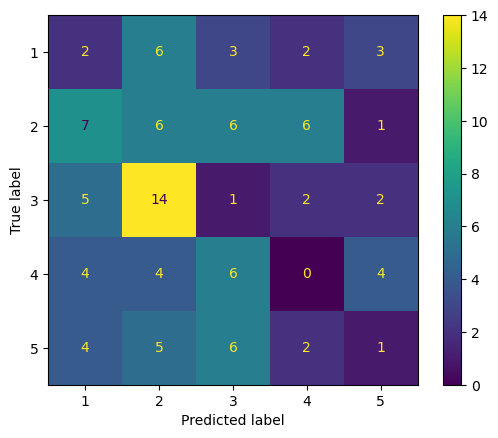

Accuracy Random Forest Classifier:  0.09803921568627451


In [10]:
ConfusionMatrixDisplay.from_predictions(Y_val, y_pred_rf)
plt.show()

acc_rf = accuracy_score(Y_val, y_pred_rf)
print("Accuracy Random Forest Classifier: ", acc_rf)

In [11]:
simple_model = tf.keras.models.Sequential([
  tf.keras.layers.Flatten(input_shape=(9,9,40)),
  tf.keras.layers.Dense(128, activation='relu'),
  tf.keras.layers.Dropout(0.2),
  tf.keras.layers.Dense(5, activation='softmax')
])

simple_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

Metal device set to: Apple M1 Pro

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-01-08 03:20:10.850616: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:306] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-01-08 03:20:10.850760: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:272] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [12]:
history = simple_model.fit(X_train, Y_train, epochs=10,validation_data=(X_val, Y_val))

Epoch 1/10


2023-01-08 03:20:15.901501: W tensorflow/core/platform/profile_utils/cpu_utils.cc:128] Failed to get CPU frequency: 0 Hz
2023-01-08 03:20:16.050018: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 1s 28ms/step - loss: 1.2292 - accuracy: 0.2030 - val_loss: 1.1263 - val_accuracy: 0.2353
Epoch 2/10
 1/13 [=>............................] - ETA: 0s - loss: 1.1838 - accuracy: 0.2500

2023-01-08 03:20:16.464346: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 0s 9ms/step - loss: 1.2509 - accuracy: 0.2327 - val_loss: 1.1296 - val_accuracy: 0.1765
Epoch 3/10
13/13 [==============================] - 0s 9ms/step - loss: 1.3106 - accuracy: 0.2079 - val_loss: 1.1500 - val_accuracy: 0.1961
Epoch 4/10
13/13 [==============================] - 0s 8ms/step - loss: 1.3397 - accuracy: 0.2104 - val_loss: 1.1379 - val_accuracy: 0.2549
Epoch 5/10
13/13 [==============================] - 0s 8ms/step - loss: 1.3652 - accuracy: 0.2426 - val_loss: 1.2080 - val_accuracy: 0.2549
Epoch 6/10
13/13 [==============================] - 0s 8ms/step - loss: 1.5164 - accuracy: 0.1980 - val_loss: 1.1292 - val_accuracy: 0.2549
Epoch 7/10
13/13 [==============================] - 0s 9ms/step - loss: 1.5837 - accuracy: 0.2252 - val_loss: 1.1443 - val_accuracy: 0.2549
Epoch 8/10
13/13 [==============================] - 0s 9ms/step - loss: 1.6215 - accuracy: 0.2376 - val_loss: 1.1363 - val_accuracy: 0.2059
Epoch 9/10
13/13 [=============

In [13]:
y_pred_dl_p = simple_model.predict(X_val)

print("Prediction example: ", y_pred_dl_p[0,:], " Class: ", np.argmax(y_pred_dl_p[0,:]))

4/4 [==============================] - 0s 4ms/step
Prediction example:  [2.1796937e-05 1.6079387e-01 3.8304406e-01 2.4884109e-01 2.0729917e-01]  Class:  2


2023-01-08 03:20:21.342342: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


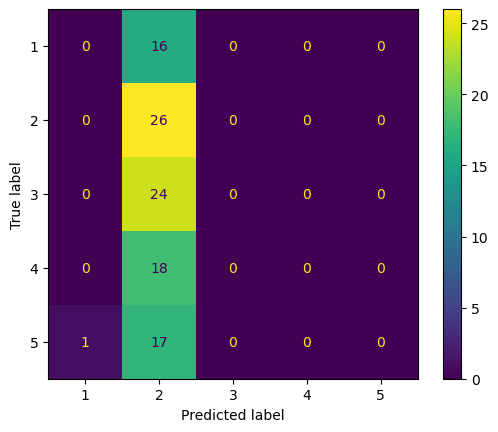

Accuracy Simple Deep Learning model:  0.2549019607843137


In [14]:
y_pred_dl = np.argmax(y_pred_dl_p, axis=1)

ConfusionMatrixDisplay.from_predictions(Y_val, y_pred_dl)
plt.show()

acc_dl = accuracy_score(Y_val, y_pred_dl)
print("Accuracy Simple Deep Learning model: ", acc_dl)

4/4 - 0s - loss: 1.1340 - accuracy: 0.2549 - 51ms/epoch - 13ms/step
0.2549019753932953


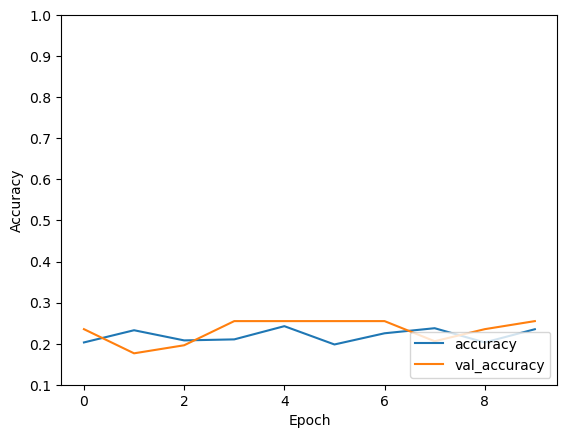

In [15]:
plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc='lower right')

test_loss, test_acc = simple_model.evaluate(X_val,  Y_val, verbose=2)

print(test_acc)

In [16]:
model = tf.keras.Sequential(
    [
    tf.keras.layers.Conv2D(9, (3,3), padding='same', activation="relu",input_shape=(9, 9, 40)),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    tf.keras.layers.Conv2D(9, (3,3), padding='same', activation="relu"),
    tf.keras.layers.MaxPooling2D((2, 2), strides=2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(64, activation="relu"),
    tf.keras.layers.Dense(5)
]
)

In [17]:

model.summary() 

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 9, 9, 9)           3249      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 9)          0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 9)           738       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 2, 2, 9)          0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 36)                0         
                                                                 
 dense_2 (Dense)             (None, 64)               

In [18]:

model.add(layers.Flatten())
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(5))

In [19]:

model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 9, 9, 9)           3249      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 4, 4, 9)          0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 4, 4, 9)           738       
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 2, 2, 9)          0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 36)                0         
                                                                 
 dense_2 (Dense)             (None, 64)               

In [20]:

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

history = model.fit(X_train, Y_train, epochs=10, 
                    validation_data=(X_val, Y_val))
     

Epoch 1/10


2023-01-08 03:20:45.047699: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 1s 33ms/step - loss: 1.3050 - accuracy: 0.2252 - val_loss: 1.2644 - val_accuracy: 0.2549
Epoch 2/10
 1/13 [=>............................] - ETA: 0s - loss: 1.2920 - accuracy: 0.2188

2023-01-08 03:20:45.511833: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


13/13 [==============================] - 0s 13ms/step - loss: 1.2212 - accuracy: 0.2673 - val_loss: 1.1940 - val_accuracy: 0.2549
Epoch 3/10
13/13 [==============================] - 0s 14ms/step - loss: 1.1535 - accuracy: 0.2698 - val_loss: 1.1628 - val_accuracy: 0.1667
Epoch 4/10
13/13 [==============================] - 0s 14ms/step - loss: 1.1644 - accuracy: 0.2129 - val_loss: 1.1760 - val_accuracy: 0.1569
Epoch 5/10
13/13 [==============================] - 0s 14ms/step - loss: 1.1551 - accuracy: 0.2401 - val_loss: 1.1332 - val_accuracy: 0.1961
Epoch 6/10
13/13 [==============================] - 0s 12ms/step - loss: 1.2224 - accuracy: 0.2079 - val_loss: 1.3711 - val_accuracy: 0.2549
Epoch 7/10
13/13 [==============================] - 0s 12ms/step - loss: 1.4304 - accuracy: 0.2277 - val_loss: 1.9910 - val_accuracy: 0.2157
Epoch 8/10
13/13 [==============================] - 0s 12ms/step - loss: 2.1432 - accuracy: 0.2178 - val_loss: 2.8808 - val_accuracy: 0.2549
Epoch 9/10
13/13 [======

4/4 - 0s - loss: 5.9118 - accuracy: 0.1569 - 64ms/epoch - 16ms/step
0.1568627506494522


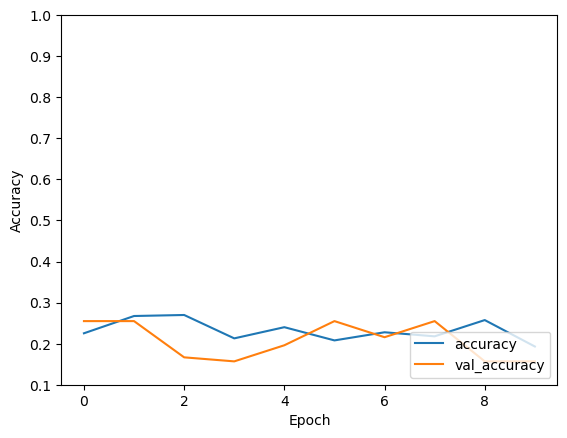

In [21]:

plt.plot(history.history['accuracy'], label='accuracy')
plt.plot(history.history['val_accuracy'], label = 'val_accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.ylim([0.1, 1])
plt.legend(loc='lower right')

test_loss, test_acc = model.evaluate(X_val,  Y_val, verbose=2)

print(test_acc)

In [22]:
y_pred_cnn_p = model.predict(X_val)

print("Prediction example: ", y_pred_cnn_p[0,:], " Class: ", np.argmax(y_pred_cnn_p[0,:]))

4/4 [==============================] - 0s 11ms/step
Prediction example:  [-1612.751  -1575.3295 -1580.4933 -1583.6124 -1582.2931]  Class:  1


2023-01-08 03:20:52.325612: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


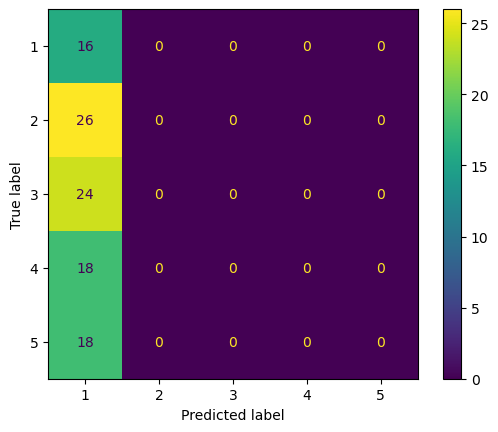

Accuracy Simple Deep Learning model:  0.1568627450980392


In [23]:
y_pred_cnn = np.argmax(y_pred_cnn_p, axis=1)

ConfusionMatrixDisplay.from_predictions(Y_val, y_pred_cnn)
plt.show()

acc_dl = accuracy_score(Y_val, y_pred_cnn)
print("Accuracy Simple Deep Learning model: ", acc_dl)